**To run this code you must use Google Colab as some of the map reduce functionality doesn't work on newer python versions.**

Task 1 – Analysis of Nuclear Plants dataset

In [ ]:
# Install pyspark as google colab doesn't carry it by default, then do all necessary imports
!pip install pyspark
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from functools import reduce
from multiprocessing import Pool
from collections import Counter
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load data from a CSV file
df = spark.read.csv("nuclear_plants_small_dataset.csv", header=True, inferSchema=True)
dataCount = df.count()
df.dropna()
missingVals = df.count() - dataCount
print(missingVals)

0


In [ ]:
# Show summary statistics for minimum, maximum, mean, and median
df.filter(df.Status=="Normal").summary("min", "max", "mean","50%").show()

df.filter(df.Status=="Abnormal").summary("min", "max", "mean","50%").show()

+-------+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+-------+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|    min|Normal|              0.0851|              0.0403|               4.3826|              0.1547|            0.0248|            0.0104|            0.0774|            0.0058|            0.0092|            0.0277|            0.0646|    

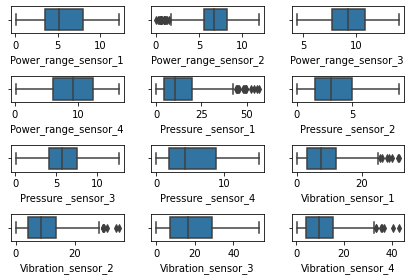

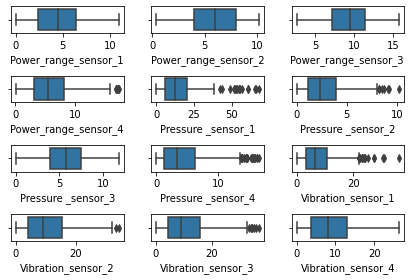

In [ ]:
def plot_box_plots(data):
    # Convert the PySpark DataFrame to a Pandas DataFrame
    pandas_df = data.toPandas()
    # Drop the 'Status' column as its non-numerical
    pandas_df.drop('Status', axis=1, inplace=True)

    # Get all of the column names
    names = list(pandas_df.columns)
    # Create a 3 wide grid of subplots
    f, axes = plt.subplots(round(len(names)/3), 3)  
    y = 0;
    # Fill in subplots with the box plot data
    for name in names:
        i, j = divmod(y, 3)
        sns.boxplot(x=pandas_df[name], ax=axes[i, j])
        y = y + 1

    # Show the box plots with nice formatting
    plt.tight_layout()
    plt.show()

plot_box_plots(df.filter(df.Status=="Normal"))
plot_box_plots(df.filter(df.Status=="Abnormal"))

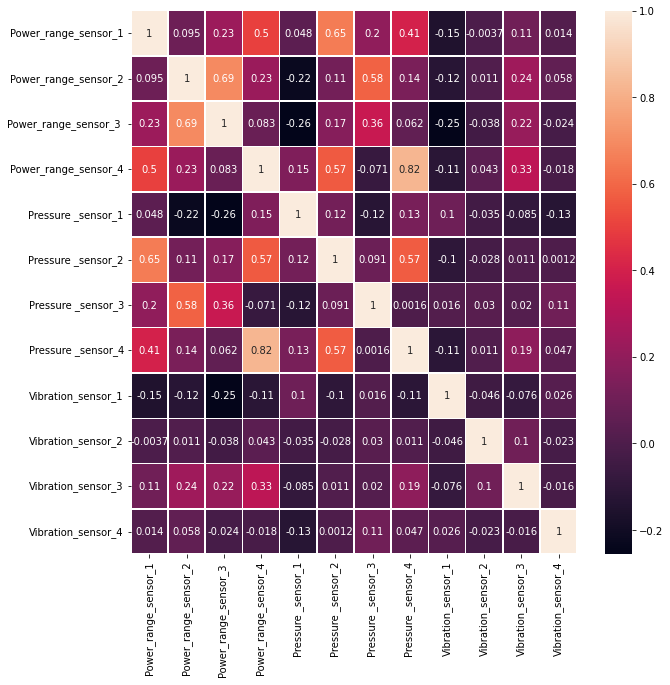

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = df.toPandas()

# Calculate the pairwise correlations between all columns
corr_matrix = pandas_df.corr()

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax)

# Show the plot
plt.show()

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = df.toPandas()
pandas_df_valid = df.toPandas()
pandas_df_valid.drop('Status', axis=1, inplace=True)

# Shuffle the samples and split them into training and testing sets
# train_test_split already shuffles using a pseudorandom number generator so we can get consistent results
X_train, X_test, y_train, y_test = train_test_split(pandas_df_valid, pandas_df['Status'], test_size=0.3, random_state=42)

# Print the number of examples in each set
print("Number of training examples:", len(X_train))
print("Number of testing examples:", len(X_test))

Number of training examples: 697
Number of testing examples: 299


In [ ]:
# Create an SVM model
svm = SVC()

# Train the SVM model on the training set
svm.fit(X_train, y_train)

# Create an ANN model
ann = MLPClassifier()

# Train the ANN model on the training set
ann.fit(X_train, y_train)

# Use the trained SVM and ANN models to make predictions on the test set
svm_predictions = svm.predict(X_test)
ann_predictions = ann.predict(X_test)

# Compute the error rate for the SVM and ANN models
svm_error_rate = (svm_predictions != y_test).mean()
ann_error_rate = (ann_predictions != y_test).mean()

# Print the error rates
print("SVM error rate:", svm_error_rate)
print("ANN error rate:", ann_error_rate)

SVM error rate: 0.21070234113712374
ANN error rate: 0.1505016722408027


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
def compute_confusion(test_set, predictions):
    # Create a confusion matrix using our test set compared to our actual predictions
    confusion = confusion_matrix(test_set,predictions)
    print('Confusion Matrix : \n', confusion)

    total=sum(sum(confusion))
    # Using the confusion matrix values, calculate overall accuracy. (true positive + true negative) / total
    accuracy=(confusion[0,0]+confusion[1,1])/total
    print ('Accuracy : ', accuracy)

    # Using the confusion matrix values, calculate overall sensitivity. true positive / (true positive + false negative)
    sensitivity = confusion[0,0]/(confusion[0,0]+confusion[0,1])
    print('Sensitivity : ', sensitivity)

    # Using the confusion matrix values, calculate overall specificity. true negative / (true negative + false positive)
    specificity = confusion[1,1]/(confusion[1,0]+confusion[1,1])
    print('Specificity : ', specificity)

compute_confusion(y_test, svm_predictions)
print('\n')
compute_confusion(y_test, ann_predictions)

Confusion Matrix : 
 [[134  11]
 [ 52 102]]
Accuracy :  0.7892976588628763
Sensitivity :  0.9241379310344827
Specificity :  0.6623376623376623


Confusion Matrix : 
 [[126  19]
 [ 26 128]]
Accuracy :  0.8494983277591973
Sensitivity :  0.8689655172413793
Specificity :  0.8311688311688312


Task 2 – MapReduce for Margie Travel dataset

In [ ]:
# Load in flight data
df = spark.read.csv("AComp_Passenger_data_no_error.csv", header=None, inferSchema=True)

# Load in airport data
top_30_df = spark.read.csv("Top30_airports_LatLong.csv", header=None, inferSchema=True)

In [ ]:
# Store our from flight names in a map, x[2] meaning that we're taking from the 3rd column
from_airport = df.rdd.map(lambda x: x[2])
# Map each string to a tuple of (string, 1)
mapped_rdd = from_airport.map(lambda x: (x, 1))

# Store our from flight names in a map, x[1] meaning that we're taking from the 2nd column
airport_names = top_30_df.rdd.map(lambda x: x[1])
# Map each string to a tuple of (string, 0)
airport_mapped_rdd = airport_names.map(lambda x: (x, 0))

# Combine our maps
combined_rdd = mapped_rdd + airport_mapped_rdd

# Reduce the tuples by their keys, summing up the counts for each string
reduced_rdd = combined_rdd.reduceByKey(lambda x, y: x + y)
results = reduced_rdd.collect()

print(results)

[('DEN', 46), ('ORD', 33), ('KUL', 33), ('LHR', 25), ('CGK', 27), ('MUC', 14), ('CDG', 21), ('CAN', 37), ('IAH', 37), ('LAS', 17), ('CLT', 21), ('ATL', 36), ('PEK', 13), ('HND', 13), ('LAX', 0), ('HKG', 0), ('SIN', 0), ('SFO', 0), ('PHX', 0), ('JFK', 25), ('MAD', 13), ('AMS', 15), ('DFW', 11), ('MIA', 11), ('PVG', 20), ('FCO', 15), ('BKK', 17), ('FRA', 0), ('DXB', 0), ('IST', 0)]


In [ ]:
# Store our from flight ids in a map, x[1] meaning that we're taking from the 2nd column
flight_id = df.rdd.map(lambda x: x[1])
# Map each string to a tuple of (string, 1)
mapped_rdd = flight_id.map(lambda x: (x, 1))
# Reduce the tuples by their keys, summing up the counts for each string, essentially counting passengers
flight_rdd = mapped_rdd.reduceByKey(lambda x, y: x + y)

# Get our map as a list
results = flight_rdd.collect()

# Add in all the extra data required.
for i in range (len(results)):
  # Use a MapReduce filter to get a row that has all the flight data we need
  filtered_rows = df.rdd.filter(lambda row: row['_c1'] == results[i][0])
  # It doesn't matter which flight data we use, so just grab the first one
  map_row = filtered_rows.first()
  # Split this row into the individual data we need
  from_airport = map_row[2]
  to_airport = map_row[3]
  departure_time_unix = map_row[4]
  flight_time_minutes = map_row[5]
  # Add this data, nicely formatted, back into our list
  results[i] += (from_airport, to_airport, time.strftime("%H:%M", time.gmtime(departure_time_unix)),
                 time.strftime("%H:%M", time.gmtime(departure_time_unix + flight_time_minutes * 60)))

print(results)

[('SQU6245R', 21, 'DEN', 'FRA', '17:14', '10:43'), ('XXQ4064B', 25, 'JFK', 'FRA', '17:05', '06:27'), ('SOH3431A', 18, 'ORD', 'MIA', '17:00', '21:10'), ('PME8178S', 18, 'DEN', 'PEK', '17:13', '15:15'), ('MBA8071P', 16, 'KUL', 'PEK', '17:04', '02:36'), ('MOO1786A', 13, 'MAD', 'FRA', '16:56', '20:00'), ('HUR0974O', 7, 'DEN', 'PVG', '17:15', '16:33'), ('GMO5938W', 25, 'LHR', 'PEK', '17:11', '10:48'), ('DAU2617A', 12, 'CGK', 'SFO', '17:23', '23:34'), ('RUM0422W', 14, 'MUC', 'MAD', '16:58', '20:12'), ('ATT7791R', 15, 'AMS', 'DEN', '17:13', '09:54'), ('WPW9201U', 11, 'DFW', 'PEK', '17:21', '17:33'), ('DKZ3042O', 11, 'MIA', 'SFO', '17:05', '02:03'), ('QHU1140O', 21, 'CDG', 'LAS', '17:14', '12:07'), ('ULZ8130D', 27, 'CAN', 'DFW', '17:23', '21:26'), ('VYU9214I', 15, 'ORD', 'DXB', '17:18', '18:28'), ('HZT2506M', 14, 'IAH', 'AMS', '17:12', '10:36'), ('EWH6301Y', 10, 'CAN', 'DFW', '17:22', '21:25'), ('VYW5940P', 17, 'LAS', 'SIN', '17:26', '00:09'), ('WSK1289Z', 21, 'CLT', 'DEN', '16:59', '21:37'), 

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
  # Convert latitudes and longitudes to radians
  lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

  # Calculate difference in latitude and longitude values
  latDiff = lat2 - lat1
  lonDiff = lon2 - lon1

  # Calculate distance in nautical miles using haversine formula
  a = math.sin(latDiff/2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(lonDiff/2) ** 2
  c = 2 * math.asin(math.sqrt(a))

  # Radius of earth in nautical miles
  r = 3443.92
  return c * r

In [ ]:
# Take passenger id, and the airport we traveled to and from
passenger_data = df.rdd.map(lambda x: [x[i] for i in [0,2,3]])

# Take airport name, latitute and longitude from the data
airport_data = top_30_df.rdd.map(lambda x: [x[i] for i in [1,2,3]])
# Create a dictionary mapping airport name to latitude and longitude so we have O(1) data retrieval
airport_dict = {}
for airport in airport_data.collect():
  airport_dict[airport[0]] = (airport[1], airport[2])

passenger_dict = {}
# Using passenger ID and which airport they traveled to and from we can map passenger ID to nautical miles
for passenger in passenger_data.collect():
  # Deconstruct our list so its easier to read
  passenger_id = passenger[0]
  from_airport_name = passenger[1]
  destination_airport_name = passenger[2]
  # Get latitude and longitude from our dictionary
  lat1 = airport_dict[from_airport_name][0]
  lon1 = airport_dict[from_airport_name][1]
  lat2 = airport_dict[destination_airport_name][0]
  lon2 = airport_dict[destination_airport_name][1]
  # Calculate nautical miles using our latitudes and longitudes
  nautical_miles = haversine(lat1, lon1, lat2, lon2)#convert_to_miles(get_distance(lat1,lon1,lat2,lon2))
  # If passenger id is in dictionary, add on to the total, if not add to dictionary
  if passenger_id in passenger_dict:
    passenger_dict[passenger_id] += nautical_miles
  else:
    passenger_dict[passenger_id] = nautical_miles

# Sort the dictionary by value so we can find out who has traveled the highest number of nautical miles
sorted_keys = sorted(passenger_dict, key=passenger_dict.get, reverse=True)
print('Passenger Id: ' + sorted_keys[0] + " Nautical Miles Traveled: {:.4f}".format(passenger_dict[sorted_keys[0]]))

Passenger Id: UES9151GS5 Nautical Miles Traveled: 132026.4343
